## [PyAMG](https://github.com/pyamg/pyamg) 
PyAMG is a Python package of algebraic multigrid (AMG) solvers and supporting tools for approximating the solution to large, sparse linear systems of algebraic equations. [https://lukeo.cs.illinois.edu/files/2023_PyAMG.pdf]

## Background
Partial Differential Equations (PDEs) are a very powerful mathematical tool to describe physical, biological, and sociological systems. They can accurately model VERY complicated situations but are usually hard to solve. [https://faculty.ucmerced.edu/fblanchette/teaching/Partial_Diff_Eqs_Notes_Blanchette.pdf]

In most numerical procedures for solving partial differential equations, usually, no real interplay is allowed between discretization and solution processes. This results in the discretization process, being unable to predict the proper resolution and the proper order of approximation at each location, produces a mesh which is too fine.
The algebraic system thus becomes unnecessarily large in size, while accuracy usually
remains rather low, since local smoothness of the solution is not being properly exploited. On the other hand, the solution process fails to take advantage of the fact that
the algebraic system to be solved does not stand by itself, but is actually an approximation to continuous equations, and therefore can itself be similarly approximated by
other (much simpler) algebraic system. [https://www.wisdom.weizmann.ac.il/~achi/LOP16.pdf]

Algebraic multigrid (AMG) methods are used to approximate solutions to (sparse)
linear systems of equations using the multilevel strategy of relaxation and coarse-grid
corrections that are used in geometric multigrid (GMG) methods. [https://lukeo.cs.illinois.edu/files/2015_Ol_encamg.pdf]

While partial diﬀerential equations (PDEs) are often the source of these linear systems, the goal in AMG is to generalize the multilevel process to target problems where the correct coarse problem is not apparent — e.g. unstructured meshes, graph problems, or structured problems
where uniform refinement is not eﬀective. [https://lukeo.cs.illinois.edu/files/2015_Ol_encamg.pdf]


In [1]:
import pyamg
import numpy as np

## [PyAMG](https://pyamg.readthedocs.io/en/latest/) Features
PyAMG features implementations of:

- Ruge-Stuben (RS) or Classical AMG
- AMG based on Smoothed Aggregation (SA)

The predominant portion of PyAMG is written in Python with a smaller amount of supporting C++ code for performance critical operations.

## [Motivation](https://lukeo.cs.illinois.edu/files/2023_PyAMG.pdf) 
The overarching goals of PyAMG include both readability and performance. This includes
readable implementations of many popular variations of AMG (see the Methods section), the
ability to reproduce results in the literature, and a user-friendly interface to AMG allowing
straightforward access to the variety of AMG parameters in the method(s).

PyAMG also allows rapid prototyping of new AMG solvers and the ability to compare with ease.


Following is a comparison between customized multilevel solver v/s a generic one to show the straightforward access to AMG parameters and its performant execution of custom solvers.

This is what the documentation says for `smoothed_aggregation_solver`

>At each level, four steps are executed in order to define the coarser
level operator.

>1. Matrix A is given and used to derive a strength matrix, C.

>2. Based on the strength matrix, indices are grouped or aggregated.
>3. The aggregates define coarse nodes and a tentative prolongation
 operator T is defined by injection

>4. The tentative prolongation operator is smoothed by a relaxation
 scheme to improve the quality and extent of interpolation from the
 aggregates to fine nodes.


The multilevel solver creates a coarse problem, for example, for a PDE of heat transfer over a 1-dimensional rod, it will break it into N sections of constant width as a way to discretize and then apply the operation on each. The `tentative prolongation operator` acts like a matrix transformation which maps coarse grid values to fine grid values since coarse grids values wouldn't be extremely accurate. But since the `tentative prologation matrix` initialized would be very rudimentary, they apply a smoothing operation to represent the smooth variations of the grid.


More examples can be found [here](https://github.com/pyamg/pyamg-examples/tree/main)



Details: Default AMG
--------------------
MultilevelSolver
Number of Levels:     5
Operator Complexity:   1.125
Grid Complexity:       1.127
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0       40000       357604 [88.91%]
     1        4489        39601 [9.85%]
     2         529         4489 [1.12%]
     3          64          484 [0.12%]
     4           9           49 [0.01%]

The residual norm is 607003.4256632833


The Multigrid Hierarchy
-----------------------
A_0:      40000x40000        P_0:      40000x4489      
A_1:       4489x4489         P_1:       4489x529       
A_2:        529x529          P_2:        529x64        
A_3:         64x64           P_3:         64x9         
A_4:          9x9         


Details: Specialized AMG
------------------------
MultilevelSolver
Number of Levels:     6
Operator Complexity:   2.159
Grid Complexity:       1.201
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0       40000       357604 [46.32%]
 

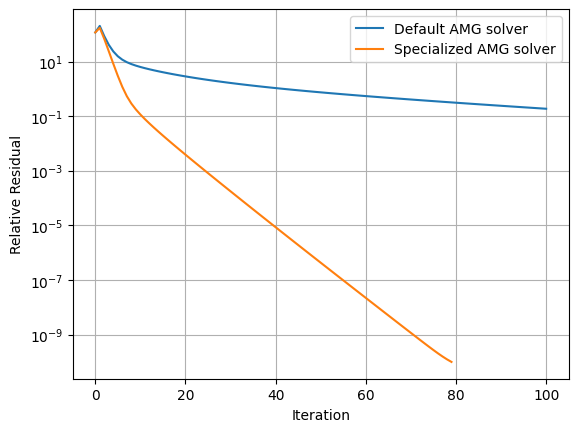

In [14]:
# ------------------------------------------------------------------
# Step 1: import scipy and pyamg packages
# ------------------------------------------------------------------
import numpy as np
import pyamg
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Step 2: setup up the system using pyamg.gallery
# ------------------------------------------------------------------
n = 200
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
stencil = pyamg.gallery.diffusion_stencil_2d(type='FE', epsilon=0.001, theta=np.pi / 3)
A = pyamg.gallery.stencil_grid(stencil, (n, n), format='csr')
b = np.random.rand(A.shape[0])                     # pick a random right hand side

# ------------------------------------------------------------------
# Step 3: setup of the multigrid hierarchy
# ------------------------------------------------------------------
ml = pyamg.smoothed_aggregation_solver(A)   # construct the multigrid hierarchy

# ------------------------------------------------------------------
# Step 4: solve the system
# ------------------------------------------------------------------
res1 = []
x = ml.solve(b, tol=1e-12, residuals=res1)  # solve Ax=b to a tolerance of 1e-12

# ------------------------------------------------------------------
# Step 5: print details
# ------------------------------------------------------------------
print("\n")
print("Details: Default AMG")
print("--------------------")
print(ml)                                 # print hierarchy information

print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector

# notice that there are 5 (or maybe 6) levels in the hierarchy
#
# we can look at the data in each of the levels
# e.g. the multigrid components on the finest (0) level
#      A: operator on level 0
#      P: prolongation operator mapping from level 1 to level 0
#      R: restriction operator mapping from level 0 to level 1
#      B: near null-space modes for level 0
#      presmoother: presmoothing function taking arguments (A,x,b)
#      postsmoother: postsmoothing function taking arguments (A,x,b)
print("\n")
print("The Multigrid Hierarchy")
print("-----------------------")
for l in range(len(ml.levels)):
    An = ml.levels[l].A.shape[0]
    Am = ml.levels[l].A.shape[1]
    if l == (len(ml.levels)-1):
        print(f"A_{l}: {An:>10}x{Am:<10}")
    else:
        Pn = ml.levels[l].P.shape[0]
        Pm = ml.levels[l].P.shape[1]
        print(f"A_{l}: {An:>10}x{Am:<10}   P_{l}: {Pn:>10}x{Pm:<10}")

# ------------------------------------------------------------------
# Step 6: change the hierarchy
# ------------------------------------------------------------------
# we can also change the details of the hierarchy
ml = pyamg.smoothed_aggregation_solver(A,  # the matrix
                                       B=X.reshape(n * n, 1),             # the representation of the near null space (this is a poor choice)
                                       BH=None,                           # the representation of the left near null space
                                       symmetry='hermitian',              # indicate that the matrix is Hermitian
                                       strength='evolution',              # change the strength of connection
                                       aggregate='standard',              # use a standard aggregation method
                                       smooth=('jacobi', {'omega': 4.0 / 3.0, 'degree': 2}),   # prolongation smoothing
                                       presmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       postsmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       improve_candidates=[('block_gauss_seidel',
                                                           {'sweep': 'symmetric', 'iterations': 4}), None],
                                       max_levels=10,                     # maximum number of levels
                                       max_coarse=5,                      # maximum number on a coarse level
                                       keep=False)                        # keep extra operators around in the hierarchy (memory)

# ------------------------------------------------------------------
# Step 7: print details
# ------------------------------------------------------------------
res2 = []                                               # keep the residual history in the solve
x = ml.solve(b, tol=1e-12, residuals=res2)              # solve Ax=b to a tolerance of 1e-12
print("\n")
print("Details: Specialized AMG")
print("------------------------")
print(ml)                                               # print hierarchy information
print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector
print("\n")

# ------------------------------------------------------------------
# Step 8: plot convergence history
# ------------------------------------------------------------------
fig, ax = plt.subplots()
ax.semilogy(res1, label='Default AMG solver')
ax.semilogy(res2, label='Specialized AMG solver')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Residual')
ax.grid(True)
plt.legend()
plt.show()

PyAMG also has a blackbox solver which can infer what solver would work best for it. If we look at the function, it checks if the matrix is hermitian, i.e. symmetric or if its not symmetric. It then sets up the other parameters accordingly. This might not guarantee convergence since it only runs a maximum of 15 iterations.

In [13]:
"""
Run the general solver routine blackbox.solve(...), which is designed to
handle an arbitrary matrix.
"""

import numpy as np
import pyamg

# Run solve(...) with the verbose option
n = 100
A = pyamg.gallery.poisson((n, n),format='csr')
b = np.random.rand(A.shape[0])
x = pyamg.solve(A,b,verb=True)

# Return the solver generated by solve(...) so that it can be used again
(x, ml) = pyamg.solve(A, b, verb=False, return_solver=True, tol=1e-8)

# run for a new right-hand-side
b2 = np.random.rand(b.shape[0])
x2 = pyamg.solve(A, b2, verb=False, existing_solver=ml, tol=1e-8)
print()

  Detected a Hermitian matrix
    maxiter = 400
    iteration 1.0
    iteration 2.0
    iteration 3.0
    iteration 4.0
    iteration 5.0
    iteration 6.0
    iteration 7.0
  Residuals ||r_k||_M, ||r_0||_M = 4.30e-05, 8.15e+02
  Residual reduction ||r_k||_M/||r_0||_M = 5.27e-08



PyAMG also has implementations of various iterative methods.

In [8]:
A = np.array([[ 4, -1, -6,  0],
              [-5, -4, 10,  8],
              [ 0,  9,  4, -2],
              [ 1,  0, -7,  5.]])
b = np.array([2, 21, -12, -6.])
x = np.array([0, 0, 0, 0.])

pyamg.relaxation.relaxation.sor(A, x, b, 0.5, iterations=1)
print(x)

[ 0.25       -2.78125     1.62890625  0.51523438]


# Questions 

// TODO

# Future work

Since one of the overarching goals of PyAMG is to make rapid prototyping of custom AMG solvers as easy as possible, what if we added more customization through parameters? For example, we could allow users to add custom smoothers for SA by specifying relaxation parameters, the number of iterations, and loop variables.